# Melting Probe Trajectory 

This code uses the Melting probe log file in the simplified form and generates the trajectory.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Reading the file
file =  open("driveU.csv")  # Opens the file
next(file) # skips first line
m = [] # to store as an array
for line in file:
    #print(line)
    m.append(line) # stores values in an array
heater = np.zeros((len(m),24)) # to store values in a matrix
f = np.asarray(m) # convert to array
time= np.zeros(len(m)) # to store timesteps

# loop to get the values in the matrix 
for i in range(0,len(m)): 
    values = f[i].split()
    time[i] = values[0] # first value stored as time
    for j in range(1,25):
        heater[i][j-1] = values[j] # Storing the heater states
#print(time)
#print(heater)     
global time

In [3]:
# Thermophysical properties for the trajectory model
rho_S=920                   # solid PCM density [kg/m^3]
rho_L=1000                  # liquid PCM density [kg/m^3]
h_m=333700                  # latent heat of melting [J/kg]
T_m=0                       # melting temperature [degC]
T_S=-17                     # ice temperature [degC]
c_p_S=2049.41               # solid PCM specific heat capacity [J/(kg*K)]
c_p_L=4222.22               # liquid PCM specific heat capacity [J/(kg*K)]
k_L=0.57                    # liquid PCM thermal conductivity [W/(m*K)]
k_S=2.18                    # solid PCM thermal conductivity [W/(m*K)]
L=2                         # length of the IceMole [m]
H=0.15                      # width of the IceMole [m]
tau=0                       # torsion [rad/m]
n_0=1,0,0                   # initial normal vector
t_0=0,0,1                   # initial tangent vector
subSteps=1000               # the number of sub-steps between each set of data points (time integration)
subStepsRecalcVelocity=0	# 0: velocity should not be recalculated during substeps; 1: velocity should not be recalculated during substeps
r_cStraight=1000000         # The curve radius that is used to imitate straight melting [m]
temporalDiscretization=0    # 0: Explicit-time integration; 1: Implicit-time integration
straightMeltingModel=1      # 0: simple energy balance, 1: improved analytical model
F_H=400                     # exerted force [N] only used if straightMeltingModel=1
mass=40                     # mass of the melting probe
gravity_vector=0,0,9.81     # gravitational acceleration vector
mu_L=0.0013                 # liquid PCM dynamic viscosity [Ns/(m^2)] only used if straightMeltingModel=1

In [4]:
# Defining the ODEs to be solved as a function

def model(z,t,v,R):
    
    # Intial conditions
    px = z[0]
    py = z[1]
    pz = z[2]
    nx = z[3]
    ny = z[4]
    nz = z[5]
    tx = z[6]
    ty = z[7]
    tz = z[8]
    
    # EFficiency correction
    Fg = -mass*9.81*tz
    alpha = np.exp(-(1.0/Fg)**0.3) # Efficiency correction
    vv = alpha * v # velocity with efficiency correction
    RR = alpha * R # Radius of curvature with efficiency correction
    
    # ODEs
    dpxdt = vv * tx
    dpydt = vv * ty
    dpzdt = vv * tz
    dtxdt = vv / RR * nx
    dtydt = vv / RR * ny
    dtzdt = vv / RR * nz
    dnxdt = -vv / RR * tx
    dnydt = -vv / RR * ty
    dnzdt = -vv / RR * tz
    
    
    return [dpxdt,dpydt,dpzdt,dnxdt,dnydt,dnzdt,dtxdt,dtydt,dtzdt]

In [6]:
# Initial condition
z0 = [0,0,0,1,0,0,0,0,-1]
n = 100
px = np.zeros(n)
py = np.zeros(n)
pz = np.zeros(n)
nx = np.zeros(n)
ny = np.zeros(n)
nz = np.zeros(n)
tx = np.zeros(n)
ty = np.zeros(n)
tz = np.zeros(n)
power_distribution = [200, 160, 160, 200, 200, 160, 160, 200, 200, 160, 160, 200, 200, 160, 160, 200, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

for j in range(0,len(time)):
    
    # Check symmetry
    
    P_q1, P_q2, P_q3, P_q4 = 0, 0, 0, 0
    for i in range(0,4):
        P_q2 = P_q2 + heater[j][i]*power_distribution[i]
    for i in range(4,8):
        P_q3 = P_q3 + heater[j][i]*power_distribution[i]
    for i in range(8,12):
        P_q4 = P_q4 + heater[j][i]*power_distribution[i]
    for i in range(12,16):
        P_q1 = P_q1 + heater[j][i]*power_distribution[i]
    
    if (P_q1==P_q4) or (P_q2==P_q3):
        straight = 1;
    else:
        straight = 0;
        
    
    P_h = 0
    for i in range(0,16):
        P_h = P_h + heater[j][i]*power_distribution[i]
    #print(P_h)

    P_w = 0
    for i in range(16,24):
        P_w = P_w + heater[j][i]*power_distribution[i]
    #print(P_w)

    v = P_h/rho_S/(h_m + c_p_S*(T_S-T_m))/(H*L)
    

    if straight == 1:
        R = np.inf
    else:
        R = 100
        
    # determining the mode
    
    D = abs((P_q1+P_q4)-(P_q2+P_q3)) - abs((P_q1+P_q2)-(P_q3+P_q4))
    if straight == 0:
        if D>0:
            if (P_q1+P_q4)>(P_q2+P_q3):
                mode = 1
                z0[3:6] = 1,0,0
            else: 
                mode = 2
                z0[3:6] = -1,0,0
        else:
            if (P_q3+P_q4)>(P_q1+P_q2):
                mode = 3
                z0[3:6] = 0,1,0
            else:
                mode = 4   
                z0[3:6] = 0,-1,0
            
    
    print(R,mode,z0)
    # Time points
    if j < (len(time)-1):
        t = np.linspace(time[j],time[j+1],n)
    else:
        t = np.linspace(time[j],time[j]+3600,n)
    #print(t)
    
    
    # solve ODE
    z = odeint(model,z0,t,args=(v,R,))
    
    if j == 0:
        px = z[:,0]
        py = z[:,1]
        pz = z[:,2]
        nx = z[:,3]
        ny = z[:,4]
        nz = z[:,5]
        tx = z[:,6]
        ty = z[:,7]
        tz = z[:,8]
    else:
        px = np.append(px,z[:,0])
        py = np.append(py,z[:,1])
        pz = np.append(pz,z[:,2])
        nx = np.append(nx,z[:,3])
        ny = np.append(ny,z[:,4])
        nz = np.append(nz,z[:,5])
        tx = np.append(tx,z[:,6])
        ty = np.append(ty,z[:,7])
        tz = np.append(tz,z[:,8])
        
    #print(px)
    z0 = z[-1]
    



100 3 [0, 0, 0, 0, 1, 0, 0, 0, -1]
inf 3 [ 0.          0.058239   -3.13943917  0.          0.99931197  0.03708898
  0.          0.03708898 -0.99931197]


<IPython.core.display.Javascript object>


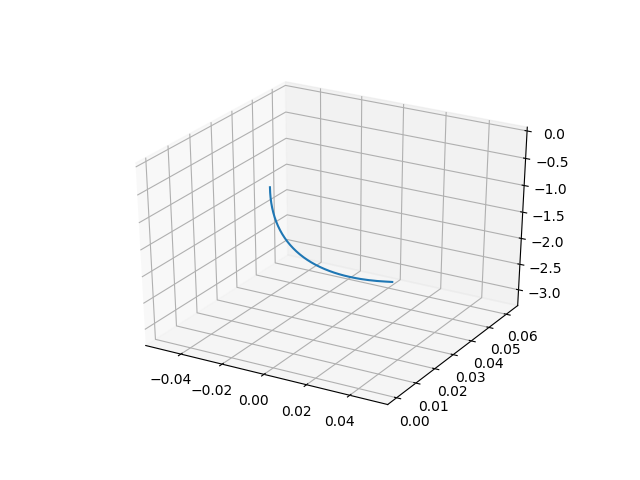

In [7]:
# Plotting Trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(px,py,pz)
plt.show()

<IPython.core.display.Javascript object>


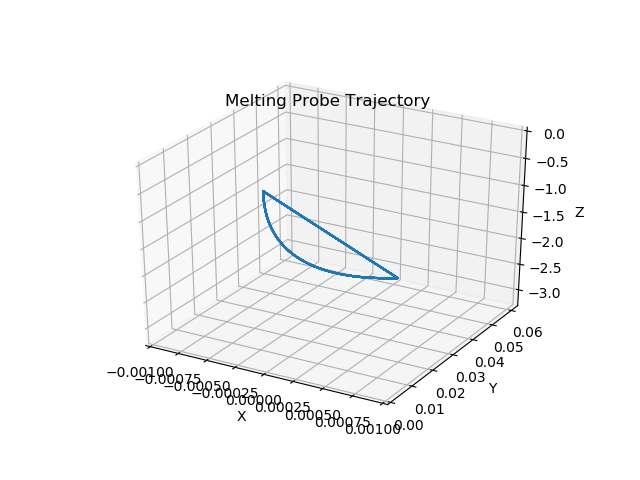

C:\Users\Sajid\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:632: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


In [9]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 


fig = plt.figure() 

ax = fig.add_subplot(111, projection='3d')
line, = ax.plot([],[],[])

# Setting the axes properties
ax.set_xlim3d([min(px), max(px)])
ax.set_xlabel('X')

ax.set_ylim3d([min(py), max(py)])
ax.set_ylabel('Y')

ax.set_zlim3d([min(pz), max(pz)])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    line.set_3d_properties([])
    return line, 

# lists to store x and y axis points 
xdata, ydata, zdata = [], [], []

# animation function 
def animate(i): 

    
    # x, y, z values to be plotted 
    x = px[i]
    y = py[i] 
    z = pz[i]
    
    # appending new points to x, y, z axes points list 
    xdata.append(x) 
    ydata.append(y) 
    zdata.append(z)
    line.set_data(xdata, ydata)
    line.set_3d_properties(zdata)
    return line, 
    
# setting a title for the plot 
plt.title('Melting Probe Trajectory') 



# call the animator	 
anim = animation.FuncAnimation(fig, animate,  init_func=init,
                                frames=len(px), interval=10, blit=True) 
